In [3]:
import numpy as np
from scipy.optimize import minimize_scalar
import scipy

from evo.core import metrics

from evo.tools import log
log.configure_logging(verbose=True, debug=True, silent=False)

import pprint


from evo.tools import plot
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

import seaborn as sns

# temporarily override some package settings
from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False


[DEBUG][2020-01-08 19:14:46,387][log.configure_logging():115]
System info:
Python 2.7.15+
Linux-4.15.0-72-generic-x86_64-with-Ubuntu-18.04-bionic
anne@ThinkPad-P50



Load two trajectory files in TUM format

In [171]:
from evo.tools import file_interface


ref_file = "room3/rgbd_dataset_freiburg3_long_office_household-groundtruth.txt"
est_file = "room3/KeyFrameTrajectory.txt"
# ref_file = "room2/rgbd_dataset_freiburg2_desk-groundtruth.txt"
# est_file = "room2/KeyFrameTrajectory.txt"
# ref_file = "room2_wdepth/rgbd_dataset_freiburg2_desk-groundtruth.txt"
# est_file = "room2_wdepth/KeyFrameTrajectory.txt"
# ref_file = "room2_uar0/rgbd_dataset_freiburg2_desk-groundtruth.txt"
# est_file = "room2_uar0/KeyFrameTrajectory.txt"
# ref_file = "room2_varscale/rgbd_dataset_freiburg2_desk-groundtruth.txt"
# est_file = "room2_varscale/KeyFrameTrajectory.txt"
# ref_file = "room1/rgbd_dataset_freiburg1_room-groundtruth.txt"
# est_file = "room1/KeyFrameTrajectory.txt"

traj_ref = file_interface.read_tum_trajectory_file(ref_file)
traj_est = file_interface.read_tum_trajectory_file(est_file)

[DEBUG][2020-01-09 12:39:01,078][file_interface.read_tum_trajectory_file():112]
Loaded 8710 stamps and poses from: room3/rgbd_dataset_freiburg3_long_office_household-groundtruth.txt
[DEBUG][2020-01-09 12:39:01,082][file_interface.read_tum_trajectory_file():112]
Loaded 178 stamps and poses from: room3/KeyFrameTrajectory.txt


In [172]:
from evo.core import sync
from evo.core import trajectory
max_diff = 0.01

traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff)
traj_est_aligned = trajectory.align_trajectory(traj_est, traj_ref, correct_scale=True, correct_only_scale=False)

[DEBUG][2020-01-09 12:39:02,425][sync.associate_trajectories():106]
Found 178 of max. 8710 possible matching timestamps between...
	first trajectory
and:	second trajectory
..with max. time diff.: 0.01 (s) and time offset: 0.0 (s).
[DEBUG][2020-01-09 12:39:02,428][trajectory.align_trajectory():394]
Aligning using Umeyama's method... (with scale correction)
[DEBUG][2020-01-09 12:39:02,437][trajectory.align_trajectory():404]
Rotation of alignment:
[[-0.9885002   0.01064016 -0.15084475]
 [ 0.13846453  0.46466139 -0.87459555]
 [ 0.06078589 -0.88542452 -0.46079116]]
Translation of alignment:
[-0.32933506  2.67901452  1.69878434]
[DEBUG][2020-01-09 12:39:02,440][trajectory.align_trajectory():405]
Scale correction: 2.39563291713


<IPython.core.display.Javascript object>


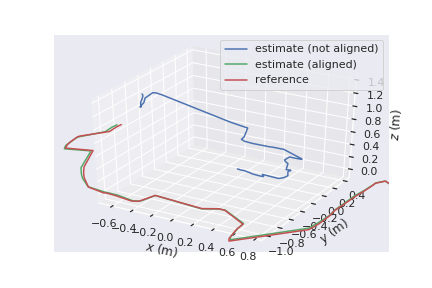

In [106]:
fig = plt.figure()
traj_by_label = {
    "estimate (not aligned)": traj_est,
    "estimate (aligned)": traj_est_aligned,
    "reference": traj_ref
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)
plt.show()

<a id='ape_math'></a>
## APE
***The absolute pose error is a metric for investigating the global consistency of a SLAM trajectory***

APE is based on the absolute relative pose between two poses $P_{ref,i}, P_{est,i} \in \mathrm{SE}(3)$ at timestamp $i$:
\begin{equation*}
E_i = P_{est,i} \ominus P_{ref,i} = P_{ref,i}^{-1} P_{est,i} \in \mathrm{SE}(3)
\end{equation*}
where $\ominus$ is the inverse compositional operator, which takes two poses and gives the relative pose [Lu-1997].
You can use different pose relations to calculate the APE:
* **`metrics.PoseRelation.translation_part`**
    * this uses the translation part of $E_i$
    * $ APE_i = \| \mathrm{trans}(E_i) \| $
* **`metrics.PoseRelation.rotation_angle_(rad/deg)`**
    * uses the rotation angle of $E_i$
    * $ APE_i = |( \mathrm{angle}(\log_{\mathrm{SO}(3)}(\mathrm{rot}(E_i)) )| $
    * $ \log_{\mathrm{SO}(3)}(\cdot) $ is the inverse of $ \exp_{\mathfrak{so}(3)}(\cdot) $ (Rodrigues' formula)
* **`metrics.PoseRelation.rotation_part`**
    * this uses the rotation part of $E_i$
    * $ APE_i = \| \mathrm{rot}(E_i) - I_{3 \times 3} \|_F $
    * unit-less
* **`metrics.PoseRelation.full_transformation`**
    * this uses the full relative pose $E_i$
    * $ APE_i = \| E_i - I_{4 \times 4} \|_F $
    * unit-less
    
Then, different statistics can be calculated on the APEs of all timestamps, e.g. the RMSE:
\begin{equation*}
\mathrm{RMSE} = \sqrt{ \frac{1}{N} \sum_{i=1}^N APE_i^2 } 
\end{equation*}

In [108]:
pose_relation = metrics.PoseRelation.translation_part
use_aligned_trajectories = True

# use aligned trajectory
if use_aligned_trajectories:
    data = (traj_ref, traj_est_aligned) 
else:
    data = (traj_ref, traj_est)
    
ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

# get a single statistic
ape_stat = ape_metric.get_statistic(metrics.StatisticsType.rmse)
print(ape_stat)

ape_stats = ape_metric.get_all_statistics()
pprint.pprint(ape_stats)

[DEBUG][2020-01-08 20:34:51,298][metrics.process_data():374]
Compared 62 absolute pose pairs.
[DEBUG][2020-01-08 20:34:51,300][metrics.process_data():376]
Calculating APE for translation part pose relation...
0.0198865031718
{'max': 0.03356147275457163,
 'mean': 0.018709917799043567,
 'median': 0.01759427342811299,
 'min': 0.0040649046263890945,
 'rmse': 0.01988650317178701,
 'sse': 0.024519326520892677,
 'std': 0.006738841469757797}


<IPython.core.display.Javascript object>


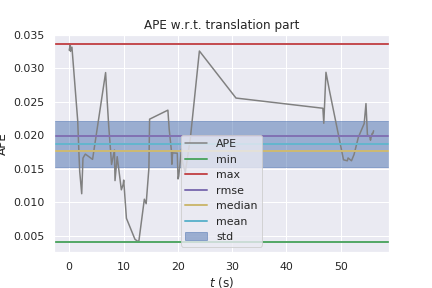

In [109]:
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps]
fig = plt.figure()
plot.error_array(fig, ape_metric.error, x_array=seconds_from_start,
                 statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                 name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

<IPython.core.display.Javascript object>


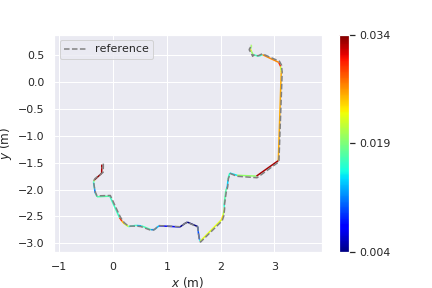

In [110]:
plot_mode = plot.PlotMode.xy
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est_aligned if use_aligned_trajectories else traj_est, ape_metric.error, 
                   plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()

### Sparse scale estimation

In [206]:

from scipy.ndimage import gaussian_filter1d

# room = "room2_wdepth/"
# room = "room2/"
# room = "room2_uar0/"
# room = "room2_varscale/"
room= "room3/"

sparse_points = np.load(room+'sparse_points.npy')
est_points = np.load(room+'est_points.npy')
targ_points = np.load(room+'targ_points.npy')
n_points = np.load(room+'n_depths.npy')

max_dist = 1.0

# keep_mask = targ_points < 2.

# est_points=est_points[keep_mask]
# sparse_points=sparse_points[keep_mask]
# targ_points=targ_points[keep_mask]


In [131]:

def filter_mask(data):
    std_mul = .2
    
    mean = np.mean(data)
    stddev = np.std(data)
    
    threshold_max = mean + std_mul*stddev
    threshold_min = mean - std_mul*stddev
    
    return np.bitwise_or(data >= threshold_max, data <= threshold_min)
    
    

<IPython.core.display.Javascript object>


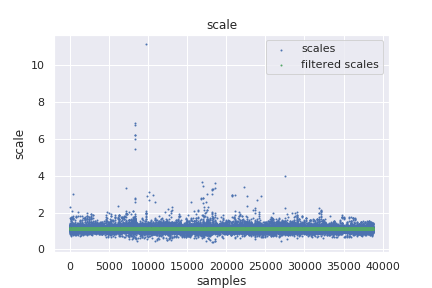

<IPython.core.display.Javascript object>


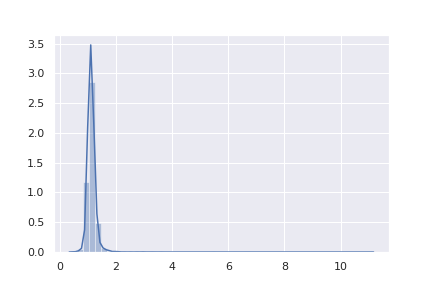

In [164]:
n_total = np.sum(n_points)

est_errors = est_points - sparse_points
est_scales = est_points/sparse_points

targ_scales = targ_points/sparse_points

# fiter errors
error_gaus = gaussian_filter1d(est_errors,100)
scale_gaus = gaussian_filter1d(est_scales,100)

# filter the scales
scale_mask = filter_mask(est_scales)
f_est_scales = np.copy(est_scales)
f_est_scales[scale_mask] = np.nan

scale_mask = filter_mask(targ_scales)
f_targ_scales = np.copy(targ_scales)
f_targ_scales[scale_mask] = np.nan




er_mask = filter_mask(error)

# plot

fig = plt.figure()
# plt.subplot(121)
plt.title("scale")
plt.xlabel("samples")
plt.ylabel("scale")
plt.scatter(np.arange(len(est_scales)), est_scales, s=1, label="scales")
plt.scatter(np.arange(len(f_est_scales)), f_est_scales, s=1, label="filtered scales")
# plt.scatter(np.arange(len(scale_gaus)), scale_gaus, s=1)
plt.legend()
plt.show()

# plt.subplot(122)
# plt.title("scale")
# plt.xlabel("samples")
# plt.ylabel("scale")
# plt.scatter(np.arange(len(targ_scales)), targ_scales, s=1, label="scales")
# plt.scatter(np.arange(len(f_targ_scales)), f_targ_scales, s=1, label="filtered scales")
# # plt.scatter(np.arange(len(scale_gaus)), scale_gaus, s=1)
# plt.legend()
# plt.show()

# fig = plt.figure()
# # plt.scatter(np.arange(len(error)), error, s=1)
# # plt.scatter(np.arange(len(_abs_error)), _abs_error, s=1)
# plt.scatter(np.arange(len(error_gaus)), error_gaus, s=1)
# plt.show()

fig = plt.figure()
sns.distplot(est_scales)
plt.show()

In [134]:
scipy.stats.describe(est_scales)
# scipy.stats.mode(scales)
# scipy.stats.tmean(scales, (1,4))
np.mean(gaus_error)
i = np.argmax(est_scales)

print(est_points[i])
print(sparse_points[i])
print(est_points[i])
scipy.stats.describe(est_scales)

18.328847885131836
1.6497608423233032
18.328847885131836


DescribeResult(nobs=38790, minmax=(0.40084108919151923, 11.11000298644495), mean=1.1263990224163027, variance=0.029291280642673577, skewness=11.26708643634098, kurtosis=444.16877387664636)

In [163]:
def _scale_error(scale, sparse, test):
    max_dist = 2.0

    scales = test/sparse
    rem_mask = filter_mask(scales)
    rem_mask = np.bitwise_and(rem_mask, test>max_dist)
    
    se = np.abs(scale*sparse[~rem_mask] - test[~rem_mask])**2
#     se = np.abs(scale*sparse - test)**2
    return se.sum()



min_scale = minimize_scalar(_scale_error, args=(sparse_points, est_points))
min_targ_scale = minimize_scalar(_scale_error, args=(sparse_points, targ_points))

print("old scale: %.3f" % scale_median)
print("est scale: %.3f" % min_scale.x)
print("targ scale: %.3f" % min_targ_scale.x)


n_prev = 0
frame_scales = []
old_frame_scales = []
frame_means = []
for n in n_points:
    if n == 0:
        continue
        
    spar = sparse_points[n_prev:n_prev+n]
    est = est_points[n_prev:n_prev+n]
    targ = targ_points[n_prev:n_prev+n]
    
    scales = est/spar
    mask = filter_mask(scales)
   
    scales = scales[~np.isnan(scales)]
    old_frame_scales.append(np.mean(scales))

    frame_scale = minimize_scalar(_scale_error, args=(spar[~mask], est[~mask]))
    
    frame_scales.append(frame_scale.x)
    
    frame_means.append(np.mean(frame_scales))
    
    n_prev += n
print("frame by frame optimize: %.3f" % np.mean(frame_scales))
print("old frame by frame: %.3f" % np.mean(old_frame_scales))
    

old scale: 1.994
est scale: 1.091
targ scale: 1.631
frame by frame optimize: 1.124
old frame by frame: 1.126


<IPython.core.display.Javascript object>


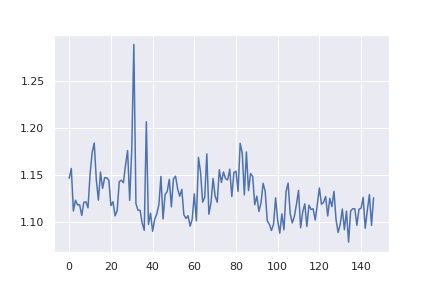

In [160]:
fig = plt.figure()
plt.plot(np.arange(len(frame_means)), frame_means)
plt.show()


## Filtering ORB points

mean error: 0.087
filtered m error: 0.066
1.6530985451548674


<IPython.core.display.Javascript object>


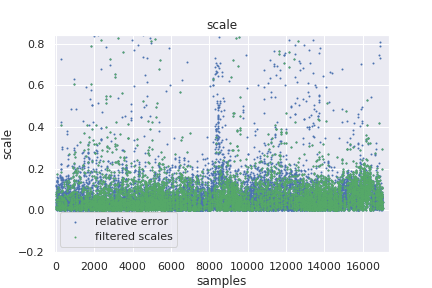

In [242]:

def filter_mask(data):
    std_mul = .5
    
    mean = np.mean(data)
    stddev = np.std(data)
    
    threshold_max = mean + std_mul*stddev
    threshold_min = mean - std_mul*stddev
    
    return np.bitwise_or(data >= threshold_max, data <= threshold_min)
    
    

def _test_scale_error(scale, sparse, test):
    se = np.abs(scale*sparse - test)**2
    return se.sum()


# targ_points
# sparse_points
# n_points
room_scale = 2.3

rel_error = np.abs((targ_points-room_scale*sparse_points)/targ_points)

n_prev = 0
sparse_filter = np.array([])
for n in n_points:
    p = np.copy(sparse_points[n_prev:n_prev+n])
    rem_mask = filter_mask(p)
    
    p[rem_mask]=np.nan
    sparse_filter = np.append(sparse_filter, p)
    
    n_prev += n
    

rel_error_filter = np.abs((targ_points-room_scale*sparse_filter)/targ_points)


print("mean error: %.3f" % np.mean(rel_error))
print("filtered m error: %.3f" % np.nanmean(rel_error_filter))
mask = np.isnan(sparse_filter)
test_scale = minimize_scalar(_test_scale_error, args=(sparse_points[~mask], est_points[~mask]))
print(test_scale.x)

fig = plt.figure()
plt.title("scale")
plt.xlabel("samples")
plt.ylabel("scale")
plt.scatter(np.arange(len(rel_error)), rel_error, s=1, label="relative error")
plt.scatter(np.arange(len(rel_error_filter)), rel_error_filter, s=1, label="filtered scales")
plt.legend()
plt.show()

In [243]:
print(mask.sum())
print(n_points.sum())

8147
17028
